In [ ]:
import torch
import json
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from collections import Counter
from transformers import AutoModelForCausalLM
from google.colab import files

In [ ]:
from google.colab import files

# Upload a single file
uploaded = files.upload()

# Access the uploaded file
for filename, content in uploaded.items():
  if "inst_0" in filename:
    with open(filename, 'wb') as f:
        f.write(content)

In [ ]:
# Auxilary functions:
def indices_of_k_most_probable_tokens(logits, k):
    # Apply softmax to get probabilities
    probabilities = F.softmax(logits, dim=-1)

    # Get the top k probabilities and corresponding indices
    top_k_values, top_k_indices = torch.topk(probabilities, k)

    # return probabilities , top_k_indices.tolist()
    return top_k_indices.tolist()

def k_most_common_indices(tensors_list, k):
    # Count occurrences of each integer
    counts = Counter(tensors_list)
    # Sort integers based on counts and select the top k
    most_common_idx_and_count = counts.most_common(k)
    most_common_idx = [x for (x,y) in most_common_idx_and_count]
    return most_common_idx

def keys_for_values(vocabulary, values):
    return [key for key, value in vocabulary.items() if value in values]

def values_for_keys(dictionary, keys):
    return [dictionary[key] for key in keys if key in dictionary]

In [ ]:
file_path = '/content/lamma2_vocab.json'
with open(file_path, 'r') as file:
  vocabulary = json.load(file)

In [ ]:
x = [round(i, 1) for i in np.arange(-5, 5.1, 0.2)]
for i, coeff in enumerate(x):
  print(coeff)
  print(i)
  print('--------------')

In [ ]:
gt_k_most_common_indices = {}
gt_most_probable_tokens_strings = {}
gt_most_probable_tokens_indices = {}
gt_norms = []

for idx in [21]:
  top_k_indices = []
  file_path = f"/content/logits_iter_{idx}.json"
  with open(file_path, 'r') as file:
    gt_curr_logits = torch.tensor(json.load(file))
    gt_norms.append(torch.norm(gt_curr_logits).item())

  # ----- find the indices in the llama2 vocabulary of the most probable tokens of coeff=0 ----- #
  gt_k_most_common_indices[idx] = indices_of_k_most_probable_tokens(gt_curr_logits, 40)
  gt_most_probable_tokens_strings[idx] = keys_for_values(vocabulary, gt_k_most_common_indices[idx])
  gt_most_probable_tokens_strings[idx] = list(filter(lambda x: any(c.isalpha() for c in x) and not '<' in x and not '>' in x, gt_most_probable_tokens_strings[idx]))
  gt_most_probable_tokens_indices[idx] = values_for_keys(vocabulary, gt_most_probable_tokens_strings[idx])

  print(gt_k_most_common_indices[idx])
  print(gt_most_probable_tokens_indices[idx])
  print(gt_most_probable_tokens_strings[idx])
  print("--------------")

[13, 29871, 259, 306, 29902, 268, 1678, 418, 539, 462, 3986, 12, 29905, 4706, 16564, 18585, 10682, 21956, 4888, 29930, 28956, 308, 14338, 320, 965, 2, 2729, 6554, 8906, 6707, 334, 30081, 29896, 29929, 9651, 795, 1576, 450, 29889, 10492]
[306, 450, 1576, 2729, 4888, 6554, 6707, 8906, 10492, 10682, 14338, 16564, 18585, 21956, 29902]
['▁I', '▁The', 'The', '▁based', 'develop', '▁rate', 'based', '▁developed', 'rate', '▁Develop', '▁developing', '▁Based', '▁Sure', 'Develop', 'I']
--------------


In [ ]:
token_indices_harmful = {}
most_probable_harmful_tokens_strings = {}
most_probable_harmful_tokens_indices = {}

for idx in range(10):
  all_top_k_indices = []
  # ----- find the indices in the llama2 vocabulary of the most probable tokens of harmful behavior responses ----- #
  for i in range(125, 150):
    file_path = f"/content/logits_iter_{i}_inst_{idx}.json"
    with open(file_path, 'r') as file:
      tensor_logits = torch.tensor(json.load(file))
      all_top_k_indices.extend(indices_of_k_most_probable_tokens(tensor_logits, 40))
  token_indices_harmful[idx] = k_most_common_indices(all_top_k_indices, 40)
  most_probable_harmful_tokens_strings[idx] = keys_for_values(vocabulary, token_indices_harmful[idx])
  most_probable_harmful_tokens_strings[idx] = list(filter(lambda x: any(c.isalpha() for c in x) and not '<' in x and not '>' in x, most_probable_harmful_tokens_strings[idx]))
  most_probable_harmful_tokens_indices[idx] = values_for_keys(vocabulary, most_probable_harmful_tokens_strings[idx])
  # print(most_probable_harmful_tokens_strings[idx])
  # print(most_probable_pos_coeff_tokens_indices[idx])
  # print("--------------")

In [ ]:
gt_logits_harmful_tokens = {}
gt_logits_top_gt_tokens = {}

for idx in range(10):
  file_path = f"/content/logits_iter_gt_inst_{idx}.json"
  with open(file_path, 'r') as file:
    gt_curr_logits = torch.tensor(json.load(file))
  gt_logits_harmful_tokens[idx] = [gt_curr_logits[curr_idx] for curr_idx in most_probable_harmful_tokens_indices[idx]]
  gt_logits_top_gt_tokens[idx] = [gt_curr_logits[curr_idx] for curr_idx in gt_most_probable_tokens_indices[idx]]

In [ ]:
gt_norms

In [ ]:
# x = [i for i in np.arange(-10, 10.5, 0.5)]
x = [round(i, 1) for i in np.arange(-10, 10.1, 0.1)]
logits_all_inst = {'projection_over_harmful_tokens': {key: {} for key in range(10)}, 'projection_over_gt_tokens': {key: {} for key in range(10)}}
all_x_plots = {'projection_over_harmful_tokens': [np.zeros(len(x)) for _ in range(10)], 'projection_over_gt_tokens': [np.zeros(len(x)) for _ in range(10)]}
coeff_norms = {'projection_over_harmful_tokens': [np.zeros(len(x)) for _ in range(10)], 'projection_over_gt_tokens': [np.zeros(len(x)) for _ in range(10)]}
gt_logits = {'projection_over_harmful_tokens': gt_logits_harmful_tokens, 'projection_over_gt_tokens': gt_logits_top_gt_tokens}
token_indices = {'projection_over_harmful_tokens': most_probable_harmful_tokens_indices, 'projection_over_gt_tokens': gt_most_probable_tokens_indices}
y_plot = x

for plot_key in all_x_plots.keys():
  for idx in range(10):
    for i, coeff in enumerate(x):
      file_path = f"/content/logits_iter_{i}_inst_{idx}.json"
      with open(file_path, 'r') as file:
        logits = json.load(file)
        curr_logits = torch.tensor(logits)
        coeff_norms[plot_key][idx][i] = torch.norm(curr_logits).item()
        curr_logits_relevant_tokens = [curr_logits[curr_idx] for curr_idx in token_indices[plot_key][idx]]
        dr = torch.tensor(curr_logits_relevant_tokens) - torch.tensor(gt_logits[plot_key][idx])
        all_x_plots[plot_key][idx][i] = torch.dot(dr, torch.tensor(gt_logits[plot_key][idx])).item()

NameError: ignored

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

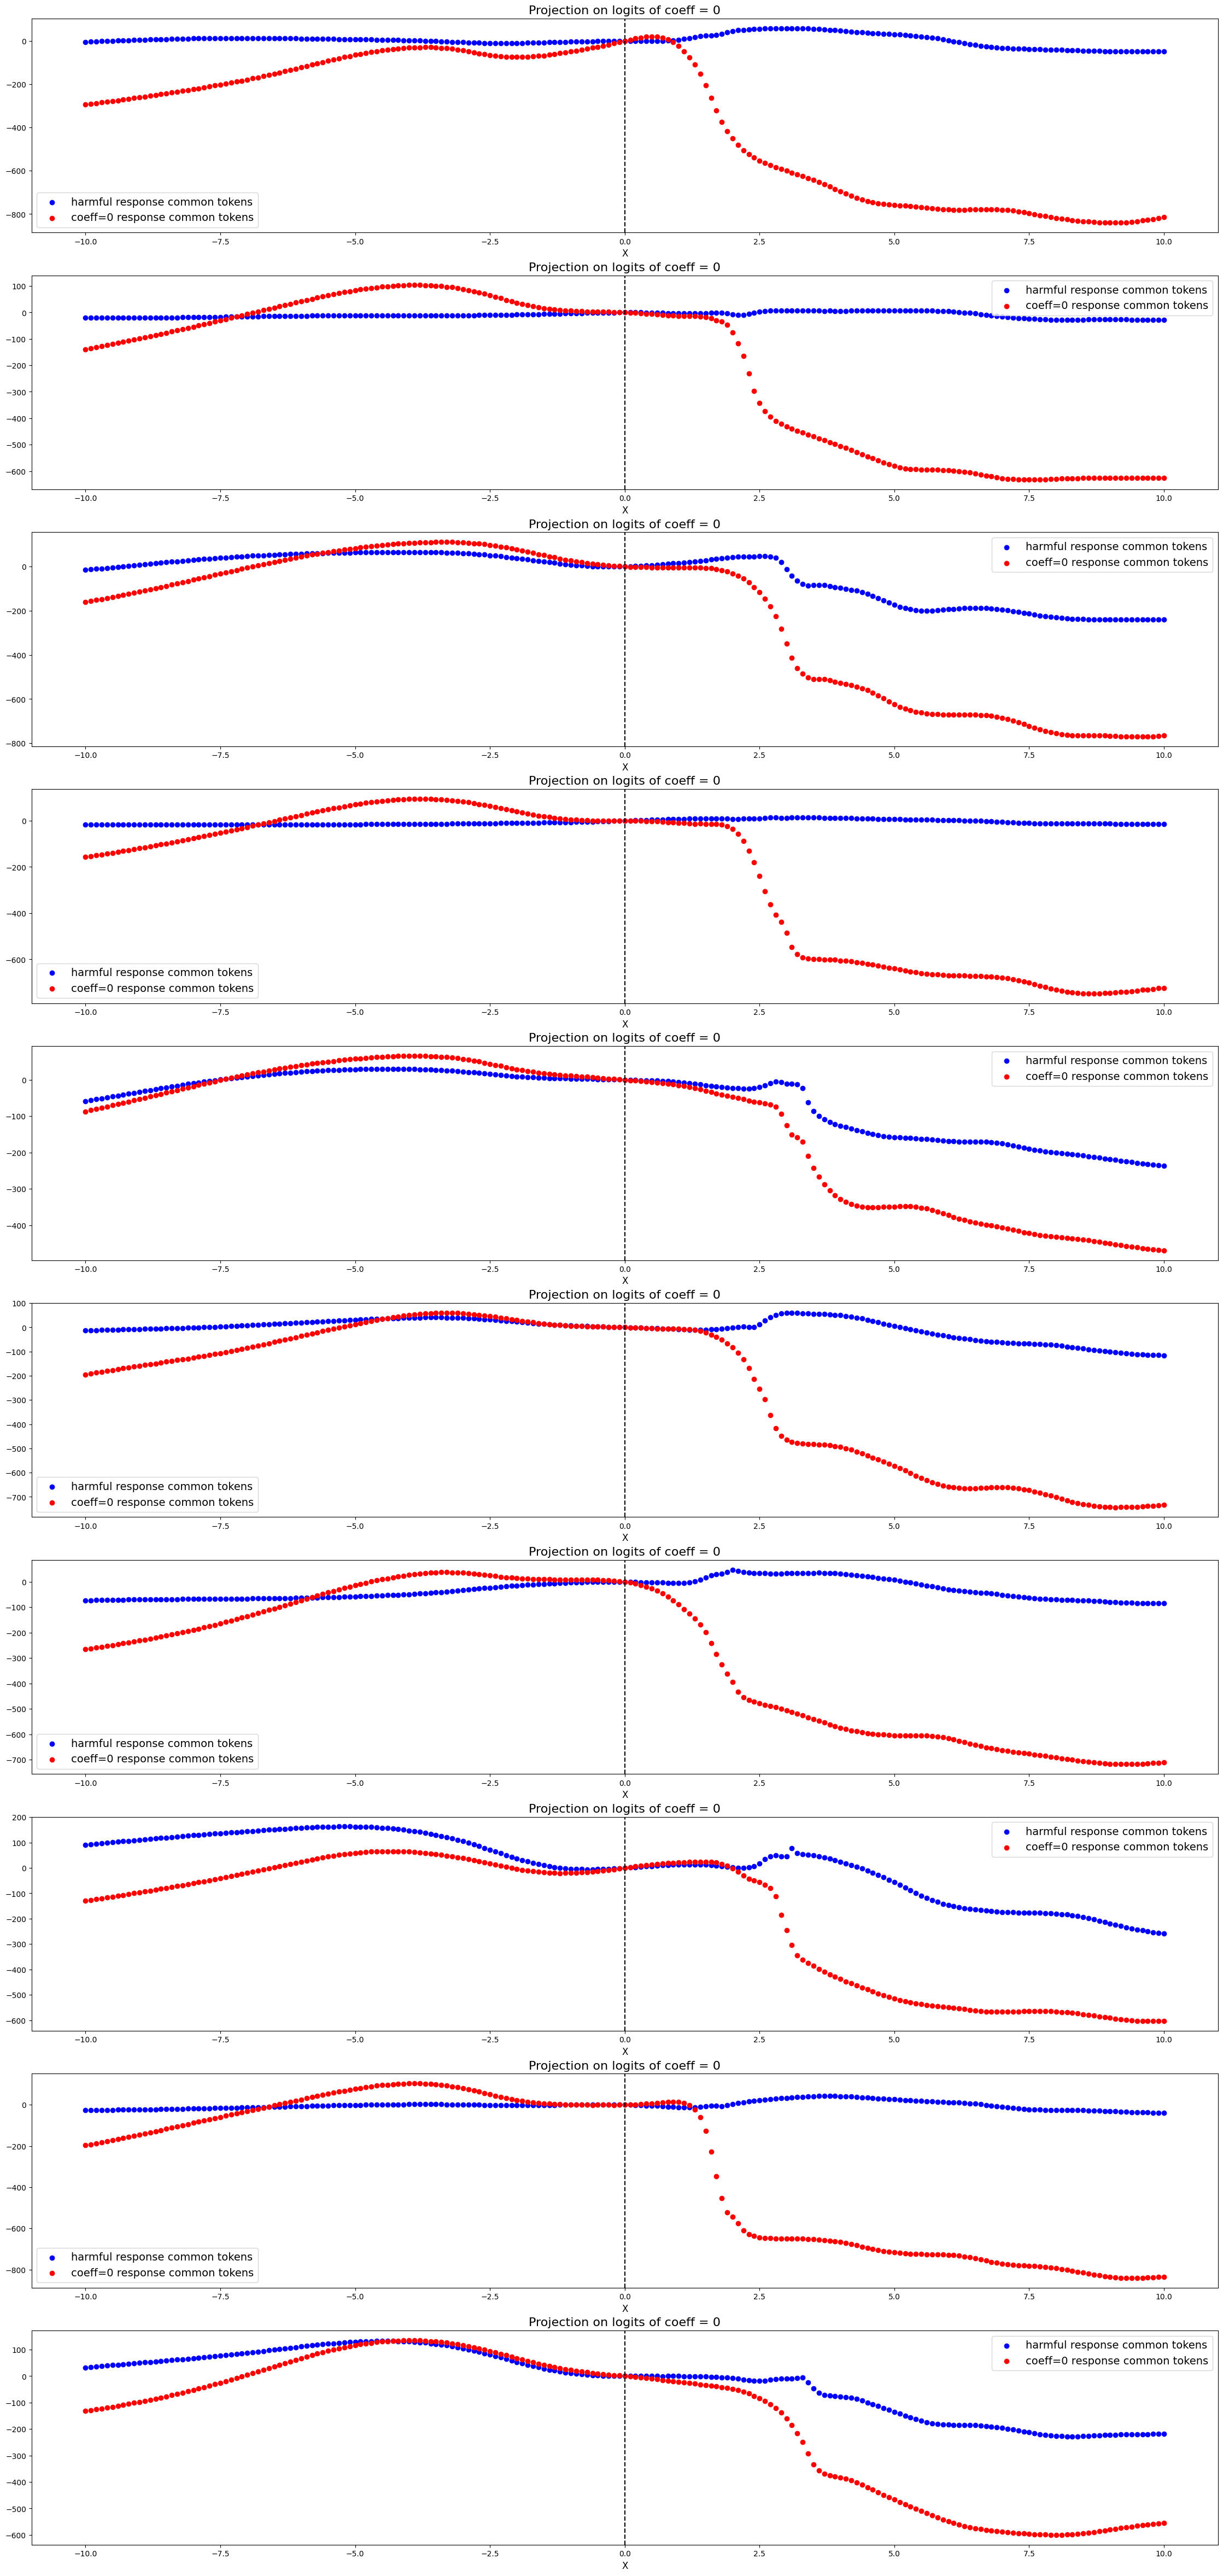

In [ ]:
x = [round(i, 1) for i in np.arange(-10, 10.1, 0.1)]
num_plots = 10
fig, axs = plt.subplots(num_plots, 1, figsize=(28, 6 * num_plots))

for k in range(num_plots):
  axs[k].scatter(x, all_x_plots['projection_over_harmful_tokens'][k] , color='blue', label='harmful response common tokens')
  axs[k].scatter(x, all_x_plots['projection_over_gt_tokens'][k] , color='red', label='coeff=0 response common tokens')
  # Marking the zero coordinate
  axs[k].axvline(x=0, linestyle='--', color='black')
  # Customizing the plot
  axs[k].set_xlabel('X', fontsize=12)
  # plt.ylabel('dot product of \'dr\' and logits of coeff = 0', fontsize=12)
  axs[k].set_title('Projection on logits of coeff = 0', fontsize=16)
  axs[k].legend(fontsize = 14)

fig.savefig('scatter_plots_separation_2_instructions_delta_2d_format.png')
# files.download('scatter_plots_separation_2_instructions_delta_2d_format.png')
plt.show()

In [ ]:
all_logit_plots = []

In [ ]:
x = [round(i, 1) for i in np.arange(-10, 10.1, 0.1)]
chosen_coeffs = []
all_logit_plots = []
all_logit_harmful_tokens = []
all_logit_top_gt_tokens = []
for idx in range(1):
  file_path = f"/content/logits_iter_gt_inst_{idx}.json"
  # with open(file_path, 'r') as file:
  #   curr_logit = torch.tensor(json.load(file))
  #   lst1 = [curr_logit[curr_idx] for curr_idx in most_probable_harmful_tokens_indices[idx]]
  #   lst1.extend([curr_logit[curr_idx] for curr_idx in gt_most_probable_tokens_indices[idx]])
  #   all_logit_plots.append(lst1)
  #   # all_logit_harmful_tokens.append()
  #   # all_logit_top_gt_tokens.append()
  for i, val in enumerate(x):
    if i % 10 == 0:
      file_path = f"/content/logits_iter_{i}_inst_{idx}.json"
      with open(file_path, 'r') as file:
        curr_logit = torch.tensor(json.load(file))
        lst1 = [curr_logit[curr_idx] for curr_idx in most_probable_harmful_tokens_indices[idx]]
        # lst1.extend([curr_logit[curr_idx] for curr_idx in gt_most_probable_tokens_indices[idx]])
        all_logit_plots.append(lst1)
        chosen_coeffs.append(val)

In [ ]:
chosen_coeffs

[-10.0,
 -9.0,
 -8.0,
 -7.0,
 -6.0,
 -5.0,
 -4.0,
 -3.0,
 -2.0,
 -1.0,
 -0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0]

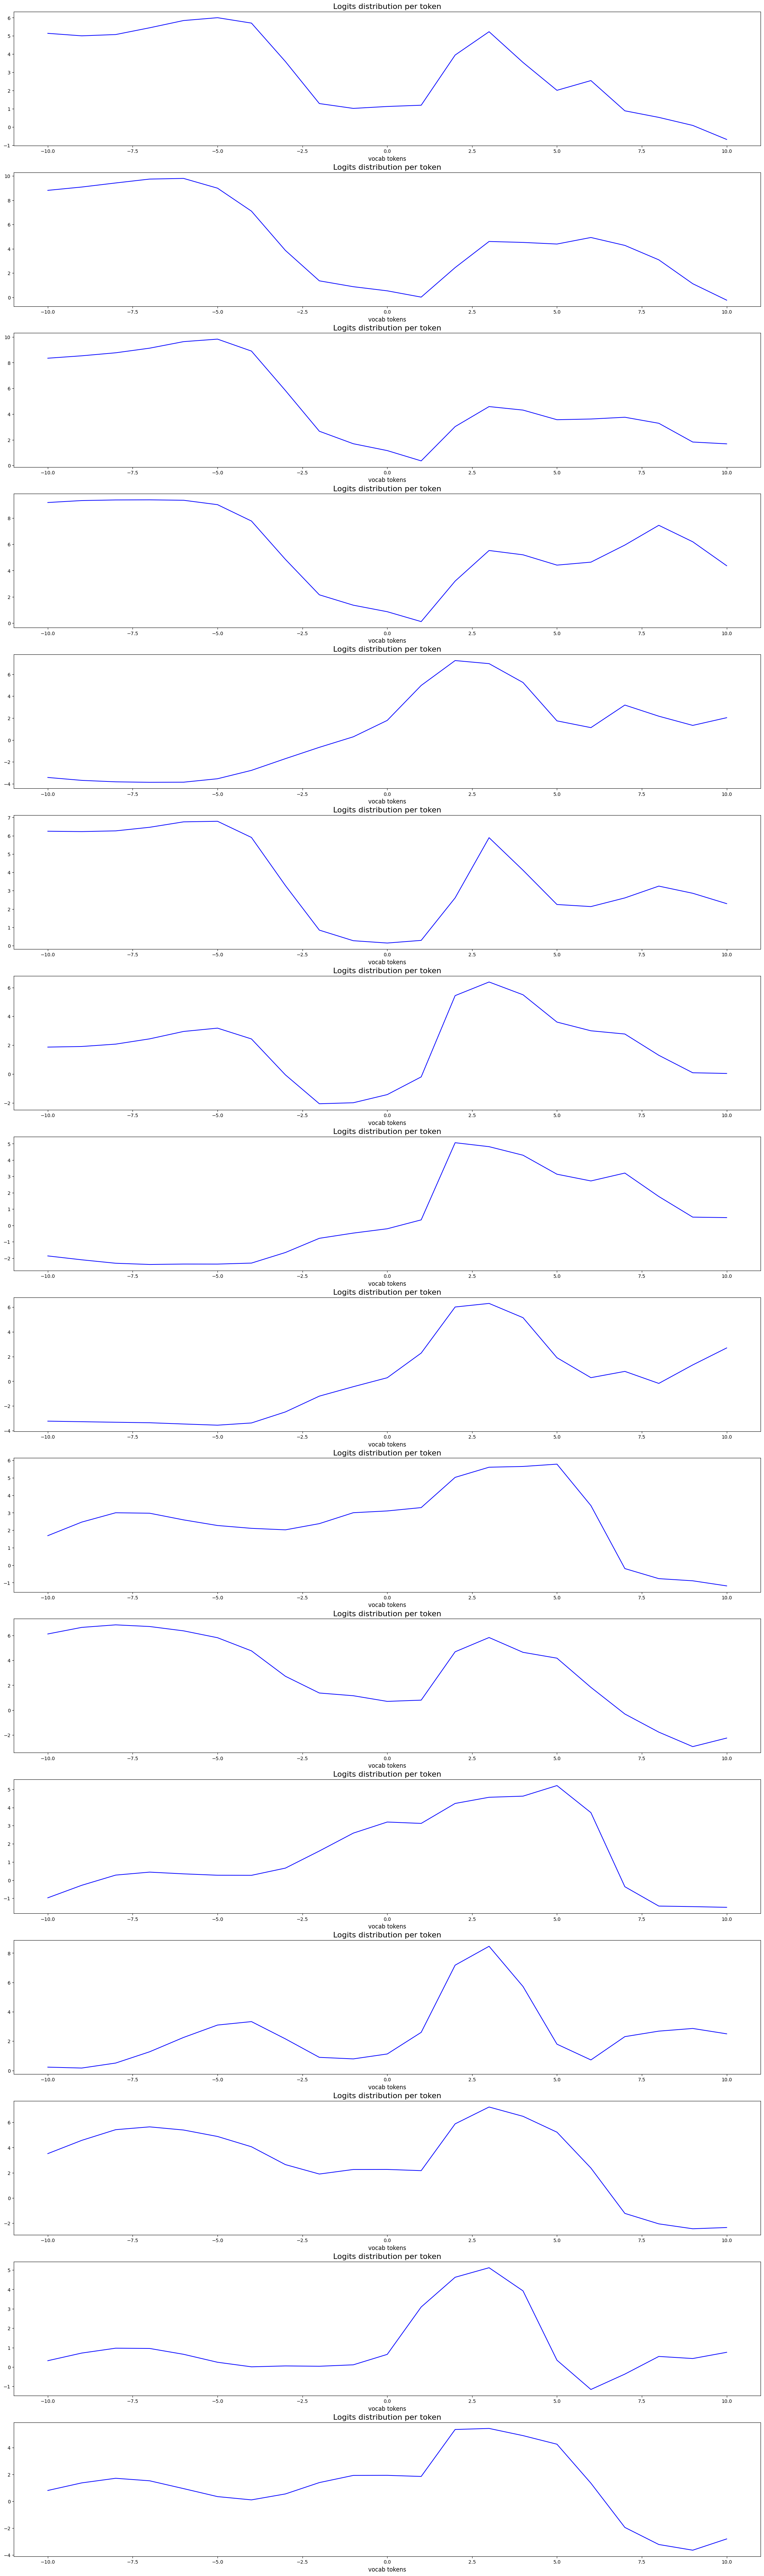

In [ ]:
# x = [k for k in range(len(all_logit_plots[0]))]
num_plots = len(all_logit_plots[0])

fig, axs = plt.subplots(num_plots, 1, figsize=(28, 6 * num_plots))

for k in range(num_plots):
  axis_x = chosen_coeffs
  axis_y = [all_logit_plots[i][k] for i in range(len(all_logit_plots))]
  # print(axis_x)
  # print(axis_y)
  axs[k].plot(axis_x, axis_y , color='blue')
  # Customizing the plot
  axs[k].set_xlabel('vocab tokens', fontsize=12)
  # plt.ylabel('dot product of \'dr\' and logits of coeff = 0', fontsize=12)
  axs[k].set_title(f'Logits distribution per token', fontsize=16)
  # axs[k].legend(fontsize = 14)

# fig.savefig('scatter_plots_separation_2_instructions_delta_2d_format.png')
# files.download('scatter_plots_separation_2_instructions_delta_2d_format.png')
plt.show()

In [ ]:
axis_y = [all_logit_plots[i][k] for i in range(len(all_logit_plots))]

In [ ]:
# fig, axs = plt.subplots(10, 1, figsize=(28, 5 * 12))
# for k, x_plot in enumerate(coeff_norms):
#   # plt.figure(figsize=(28, 4))
#   axs[k].scatter(x_plot[60:100], np.zeros_like(x_plot[60:100]) , color='blue', label='coeff < 0 points')
#   axs[k].scatter(x_plot[101:141], np.zeros_like(x_plot[101:141]) , color='red', label='coeff > 0 points')
#   axs[k].scatter(x_plot[100], np.zeros_like(x_plot[100]) , color='BLACK', label='coeff = 0')
#   # # Labeling each point on the scatter plot
#   # for i, (x, label) in enumerate(zip(x_plot[:], y_plot[:])):
#   #   plt.text(x, 0.002, label, ha='center', va='bottom', fontsize=8)
#   # Customizing the plot
#   axs[k].set_xlabel('X', fontsize=12)
#   # plt.ylabel('dot product of \'dr\' and logits of coeff = 0', fontsize=12)
#   axs[k].set_title('logit norms', fontsize=16)
#   axs[k].legend(fontsize = 14)

# fig.savefig('logit_norms_10_instructions.png')
# files.download('logit_norms_10_instructions.png')
# plt.show()

In [ ]:
# all_x_plots

In [ ]:
# fig, axs = plt.subplots(10, 1, figsize=(28, 5 * 12))
# for k, x_plot in enumerate(all_x_plots):
#   # plt.figure(figsize=(28, 4))
#   axs[k].scatter(x_plot[60:100], np.zeros_like(x_plot[60:100]) , color='blue', label='coeff < 0 points')
#   axs[k].scatter(x_plot[101:141], np.zeros_like(x_plot[101:141]) , color='red', label='coeff > 0 points')
#   axs[k].scatter(x_plot[100], np.zeros_like(x_plot[100]) , color='BLACK', label='coeff = 0')
#   # Marking the zero coordinate
#   axs[k].axvline(x=0, linestyle='--', color='black')
#   # # Labeling each point on the scatter plot
#   # for i, (x, label) in enumerate(zip(x_plot[:], y_plot[:])):
#   #   plt.text(x, 0.002, label, ha='center', va='bottom', fontsize=8)
#   # Customizing the plot
#   axs[k].set_xlabel('X', fontsize=12)
#   # plt.ylabel('dot product of \'dr\' and logits of coeff = 0', fontsize=12)
#   axs[k].set_title('Projection on logits of coeff = 0', fontsize=16)
#   axs[k].legend(fontsize = 14)

# fig.savefig('scatter_plots_separation_10_instructions.png')
# files.download('scatter_plots_separation_10_instructions.png')
# plt.show()

In [ ]:
# coeff_plus_2 = torch.tensor([2.470703125, 2.650390625, 6.33984375, 2.669921875, 8.5078125, 3.9296875])
# coeff_minus_2 = torch.tensor([6.89453125, 7.98828125, 14.5390625, 13.7578125, 9.7734375, 8.5625])
# gt = torch.tensor([18.21875, 13.4296875, 10.984375, 10.9765625, 9.6171875, 9.5625, 8.7109375, 8.5390625, 8.53125, 8.5078125, 8.421875, 8.2734375, 8.2578125, 8.21875, 8.171875, 8.109375, 8.015625, 7.8671875, 7.8515625, 7.57421875])
# indices = [17, 12, 2, 4, 7, 10]

# execution_dict = {'Here':[10605], 'Develop': [21956], 'Yes': [8241], 'Collect':[28916]}
# gt_dict = {'Sorry': [8221], 'cannot': [2609], 'As': [2887, 1094], 'I': [29902, 306]}

In [ ]:
# x_plot_trim = x_plot[9:-9]
# # Shift all values by a constant to make them positive (adjust the constant as needed)
# shifted_data = x_plot_trim - min(x_plot_trim) + 1  # Adding 1 to avoid log(0)
# # Log normalize the shifted data
# log_normalized = np.log(shifted_data)

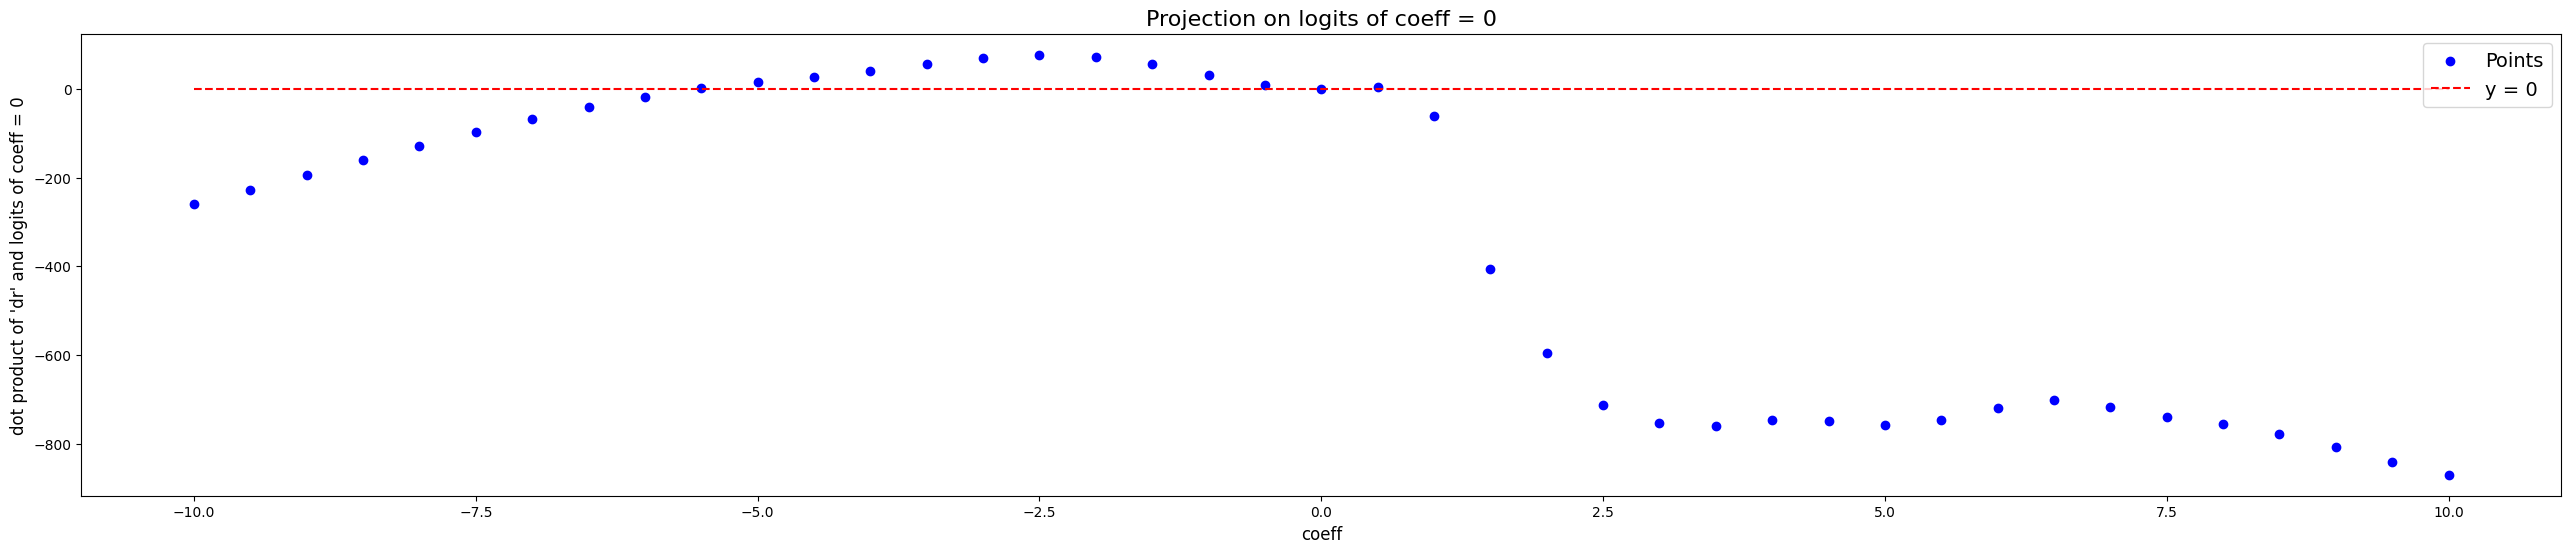

In [ ]:
# plt.figure(figsize=(32, 6))
# plt.scatter(y_plot , x_plot , color='blue', label='Points')
# # Marking the zero coordinate
# plt.hlines(y=0, xmin = -10, xmax=10, color='red', linestyle='--', label='y = 0')
# # Labeling each point on the scatter plot
# # for i, (x, label) in enumerate(zip(x_plot_trim, coeff_labels)):
# #   if i % 2 == 0:
# #     plt.text(x, 0.002, label, ha='center', va='bottom', fontsize=8)
# #   else:
# #     plt.text(x, -0.008, label, ha='center', va='bottom', fontsize=8)
# # Customizing the plot
# plt.xlabel('coeff', fontsize=12)
# plt.ylabel('dot product of \'dr\' and logits of coeff = 0', fontsize=12)
# plt.title('Projection on logits of coeff = 0', fontsize=16)
# plt.legend(fontsize = 14)
# plt.show()

In [ ]:
# [ 2609,  8221, 29902,   306,  2887,  1094]